In [44]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score
)
import warnings
warnings.filterwarnings('ignore')

In [45]:
!pip install autogluon

In [46]:
# Configuración
pd.set_option("display.max_columns", None)
plt.style.use('seaborn-v0_8')
RANDOM_SEED = 42
CSV_PATH = "diabetes.csv"

In [47]:
# ===================================================================
# 2. CARGA Y PREPARACIÓN DEL CONJUNTO DE DATOS
# ===================================================================

print("=" * 60)
print("CARGA DEL CONJUNTO DE DATOS")
print("=" * 60)

# Cargar datos
df = pd.read_csv(CSV_PATH)
print(f" Dimensiones del dataset: {df.shape}")

# Mostrar primeras filas
print("\n Primeras 3 filas del dataset:")
print(df.head(3))

# Verificar columnas esperadas (ajustando nombres según tu dataset)
expected_cols = [
    "Pregnancies",
    "GlucosePlasma",  # o "Glucose" según tu archivo
    "BloodPressure",
    "Skin",  # o "SkinThickness"
    "Insulin",
    "BMI",
    "DiabetesPedigreeFunction",
    "Age",
    "Outcome",
]

# Ajustar nombres de columnas si es necesario
column_mapping = {
    'Glucose': 'GlucosePlasma',
    'SkinThickness': 'Skin'
}

for old_name, new_name in column_mapping.items():
    if old_name in df.columns:
        df = df.rename(columns={old_name: new_name})

print(f"\n Columnas en el dataset: {list(df.columns)}")

# Información del dataset
print("\n Información general del dataset:")
print(df.info())

# Glosario de variables
variable_info = {
    "Pregnancies": "Número de veces que ha estado embarazada",
    "GlucosePlasma": "Concentración de glucosa en plasma",
    "BloodPressure": "Presión diastólica (mm Hg)",
    "Skin": "Grosor del pliegue cutáneo del tríceps (mm)",
    "Insulin": "Insulina sérica a las 2 horas (µU/ml)",
    "BMI": "Índice de masa corporal (kg / m²)",
    "DiabetesPedigreeFunction": "Función de pedigree de diabetes (riesgo familiar)",
    "Age": "Edad (años)",
    "Outcome": "Etiqueta: 1 = diabetes, 0 = no diabetes",
}

glosario_df = pd.DataFrame([
    {"Variable": k, "Descripción": v}
    for k, v in variable_info.items()
]).set_index("Variable")

print("\n Glosario de variables:")
print(glosario_df)


CARGA DEL CONJUNTO DE DATOS
 Dimensiones del dataset: (768, 9)

 Primeras 3 filas del dataset:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  

 Columnas en el dataset: ['Pregnancies', 'GlucosePlasma', 'BloodPressure', 'Skin', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

 Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null

In [48]:
# ===================================================================
# 3. ANÁLISIS EXPLORATORIO DE DATOS (EDA)
# ===================================================================

print("\n" + "=" * 60)
print("ANÁLISIS EXPLORATORIO DE DATOS")
print("=" * 60)

# Estadísticas descriptivas
print("\n📊 Estadísticas descriptivas:")
desc_stats = df.describe().T
print(desc_stats)

# Verificar valores nulos
print(f"\n🔍 Valores nulos por columna:")
null_counts = df.isnull().sum()
print(null_counts)

# Verificar valores cero (pueden ser problemáticos en variables médicas)
numeric_cols = df.select_dtypes(include=[np.number]).columns.drop('Outcome')
print(f"\n⚠️ Valores cero por columna (pueden indicar datos faltantes):")
zero_counts = (df[numeric_cols] == 0).sum()
print(zero_counts)

# Balance de clases
print(f"\n⚖️ Balance de clases en Outcome:")
outcome_counts = df["Outcome"].value_counts()
outcome_pct = df["Outcome"].value_counts(normalize=True) * 100
balance_df = pd.DataFrame({
    'Conteo': outcome_counts,
    'Porcentaje': outcome_pct.round(2)
})
print(balance_df)


ANÁLISIS EXPLORATORIO DE DATOS

📊 Estadísticas descriptivas:
                          count        mean         std     min       25%  \
Pregnancies               768.0    3.845052    3.369578   0.000   1.00000   
GlucosePlasma             768.0  120.894531   31.972618   0.000  99.00000   
BloodPressure             768.0   69.105469   19.355807   0.000  62.00000   
Skin                      768.0   20.536458   15.952218   0.000   0.00000   
Insulin                   768.0   79.799479  115.244002   0.000   0.00000   
BMI                       768.0   31.992578    7.884160   0.000  27.30000   
DiabetesPedigreeFunction  768.0    0.471876    0.331329   0.078   0.24375   
Age                       768.0   33.240885   11.760232  21.000  24.00000   
Outcome                   768.0    0.348958    0.476951   0.000   0.00000   

                               50%        75%     max  
Pregnancies                 3.0000    6.00000   17.00  
GlucosePlasma             117.0000  140.25000  199.00  

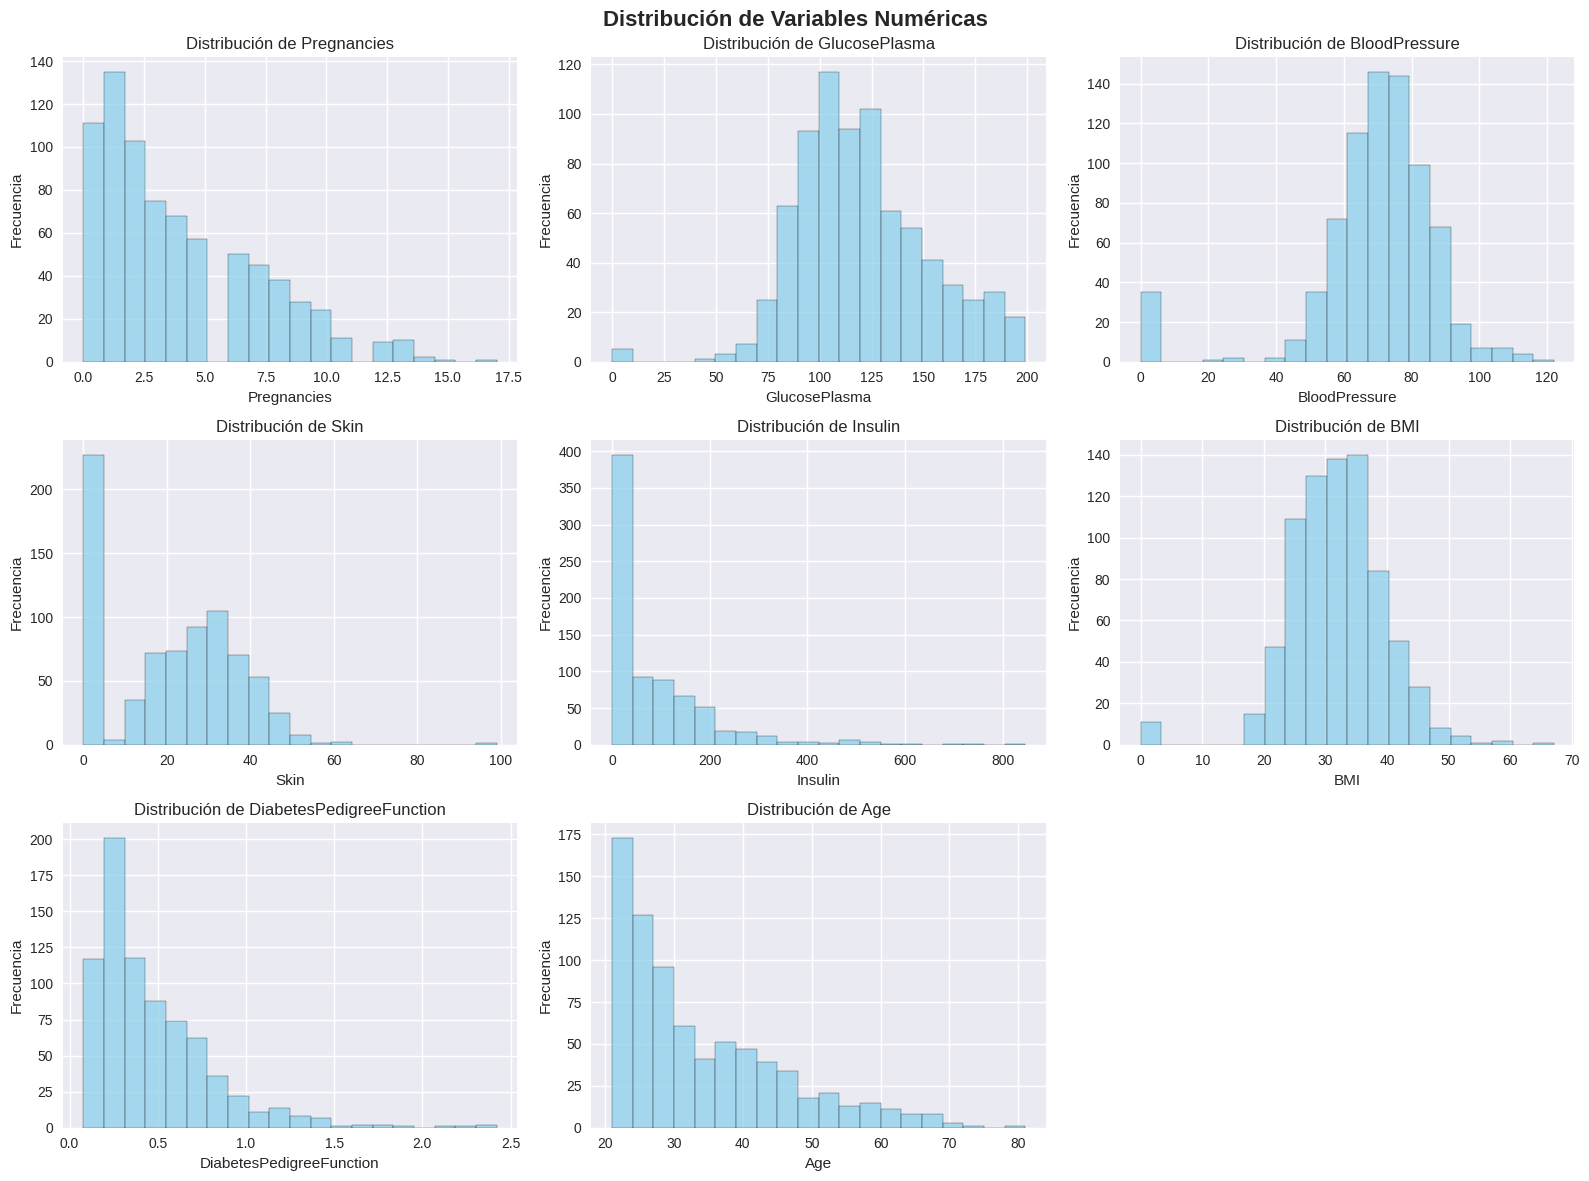

In [49]:
# ===================================================================
# 4. VISUALIZACIONES
# ===================================================================
# Histogramas de distribuciones
plt.figure(figsize=(16, 12))
numeric_features = [col for col in df.columns if col != 'Outcome']

for i, col in enumerate(numeric_features, 1):
    plt.subplot(3, 3, i)
    plt.hist(df[col], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')

plt.suptitle('Distribución de Variables Numéricas', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


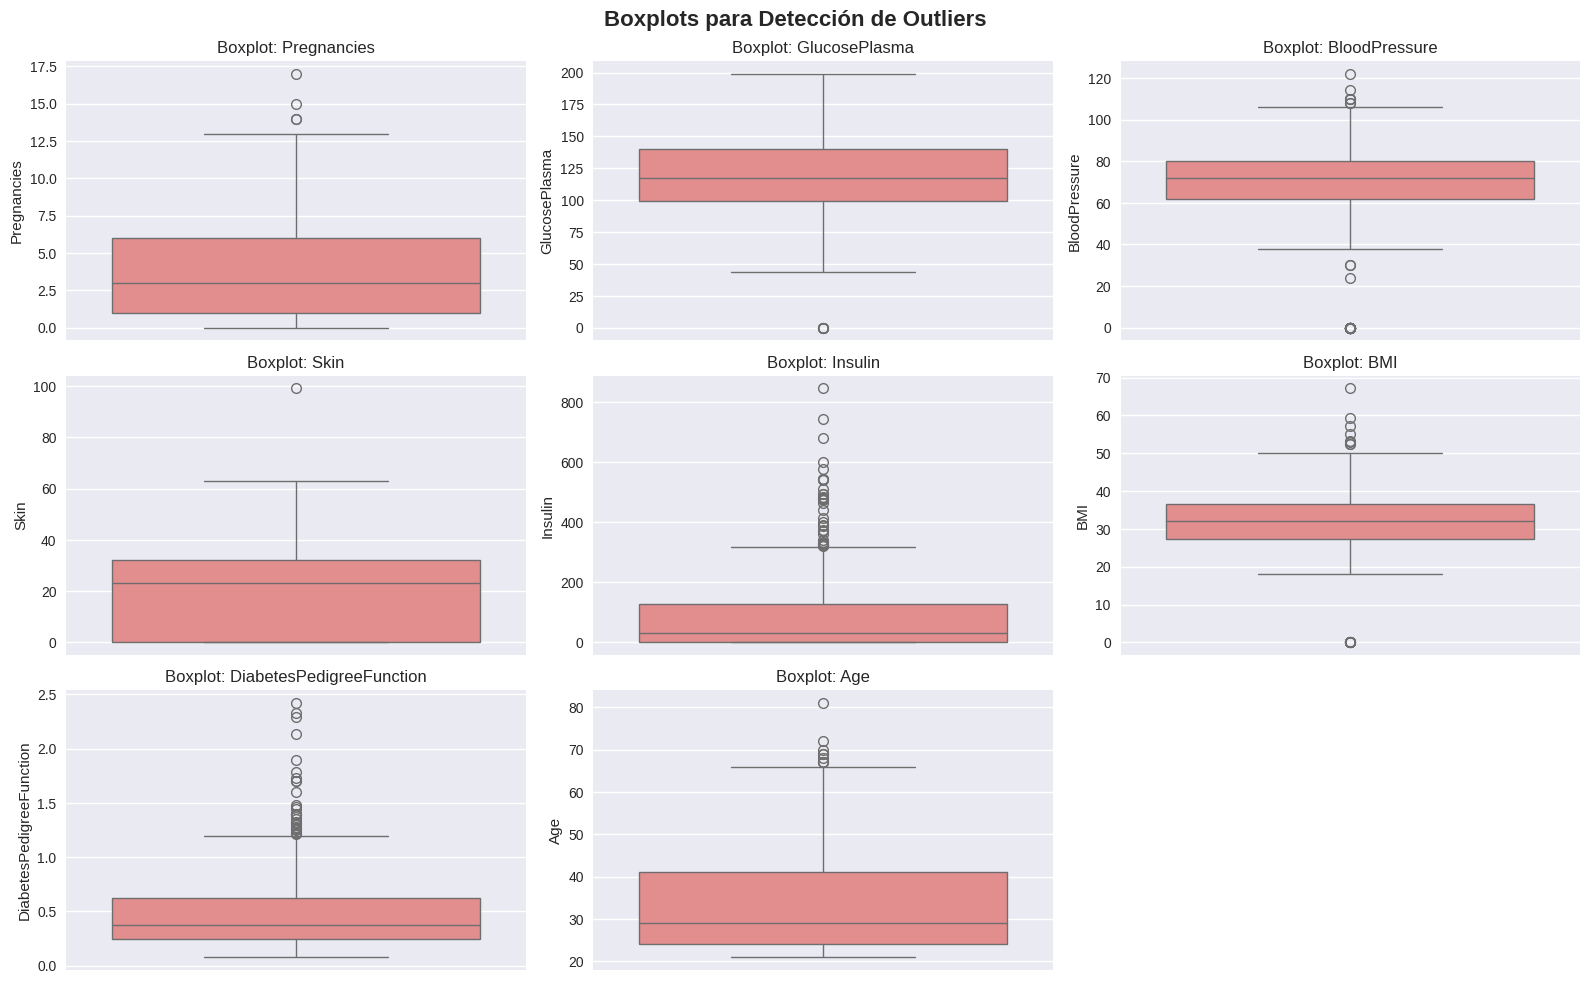

In [50]:
# Boxplots para detectar outliers
plt.figure(figsize=(16, 10))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[col], color='lightcoral')
    plt.title(f'Boxplot: {col}')

plt.suptitle('Boxplots para Detección de Outliers', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

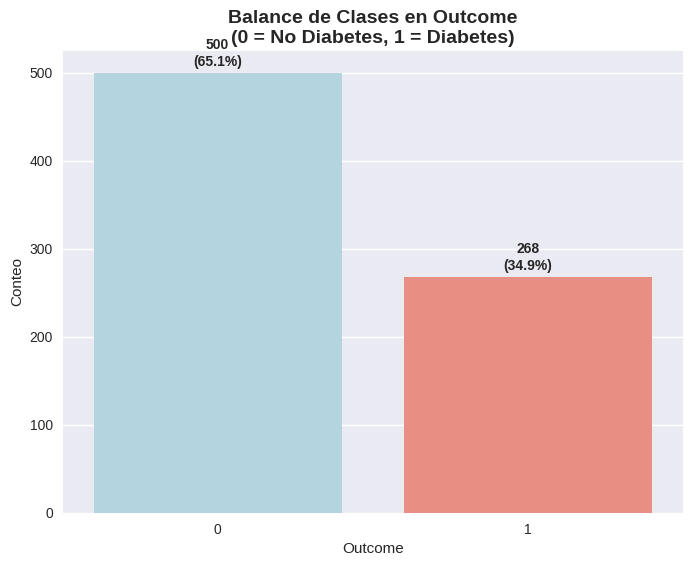

In [51]:
# Balance de clases
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Outcome', palette=['lightblue', 'salmon'])
plt.title('Balance de Clases en Outcome\n(0 = No Diabetes, 1 = Diabetes)',
          fontsize=14, fontweight='bold')
plt.xlabel('Outcome')
plt.ylabel('Conteo')

# Agregar etiquetas con porcentajes
total = len(df)
for i, (label, count) in enumerate(outcome_counts.items()):
    plt.text(i, count + 5, f'{count}\n({count/total*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold')

plt.show()

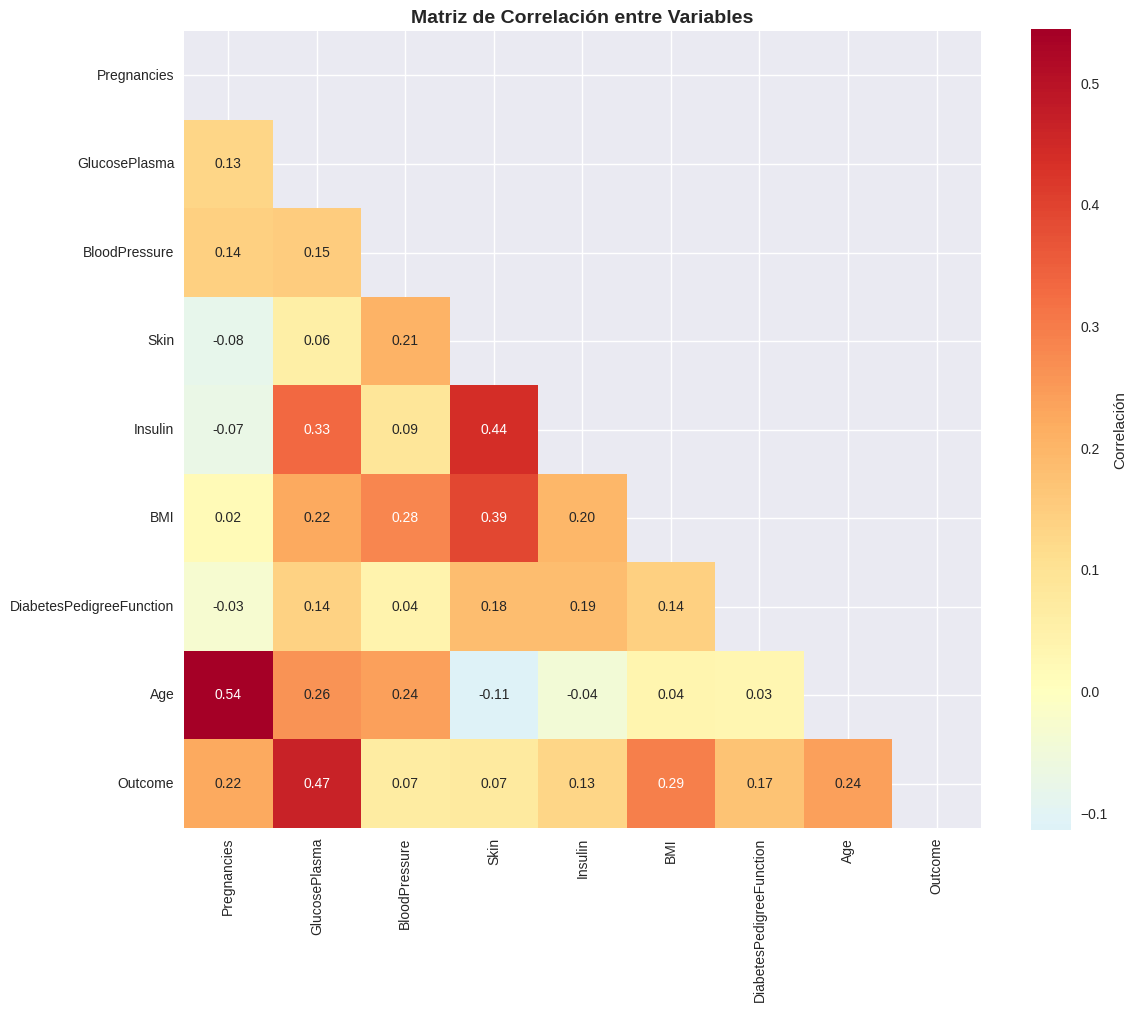

In [52]:
# Matriz de correlación
plt.figure(figsize=(12, 10))
corr_matrix = df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix,
            mask=mask,
            annot=True,
            fmt='.2f',
            cmap='RdYlBu_r',
            center=0,
            square=True,
            cbar_kws={'label': 'Correlación'})

plt.title('Matriz de Correlación entre Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [53]:
# Análisis de correlaciones más altas con Outcome
outcome_corr = corr_matrix['Outcome'].drop('Outcome').abs().sort_values(ascending=False)
print(f"\n Variables más correlacionadas con Outcome:")
print(outcome_corr.head())


 Variables más correlacionadas con Outcome:
GlucosePlasma               0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Name: Outcome, dtype: float64


In [54]:
# ===================================================================
# 5. PREPARACIÓN DE DATOS PARA AUTOGLUON
# ===================================================================

# Dividir en características y variable objetivo
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y
)

# Crear DataFrames completos para AutoGluon
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

print(f" Tamaño conjunto de entrenamiento: {train_data.shape}")
print(f" Tamaño conjunto de prueba: {test_data.shape}")

print(f"\n Balance en conjunto de entrenamiento:")
print(train_data['Outcome'].value_counts(normalize=True).round(3))

print(f"\n Balance en conjunto de prueba:")
print(test_data['Outcome'].value_counts(normalize=True).round(3))

 Tamaño conjunto de entrenamiento: (614, 9)
 Tamaño conjunto de prueba: (154, 9)

 Balance en conjunto de entrenamiento:
Outcome
0    0.651
1    0.349
Name: proportion, dtype: float64

 Balance en conjunto de prueba:
Outcome
0    0.649
1    0.351
Name: proportion, dtype: float64


In [55]:
# ===================================================================
# 6. MODELO BASELINE (REGRESIÓN LOGÍSTICA)
# ===================================================================

# Entrenar modelo baseline
baseline_model = LogisticRegression(random_state=RANDOM_SEED, max_iter=1000)
baseline_model.fit(X_train, y_train)

# Predicciones del baseline
y_pred_baseline = baseline_model.predict(X_test)
y_pred_proba_baseline = baseline_model.predict_proba(X_test)[:, 1]

# Métricas del baseline
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
baseline_precision = precision_score(y_test, y_pred_baseline)
baseline_recall = recall_score(y_test, y_pred_baseline)
baseline_f1 = f1_score(y_test, y_pred_baseline)
baseline_auc = roc_auc_score(y_test, y_pred_proba_baseline)

baseline_results = {
    'Modelo': 'Regresión Logística (Baseline)',
    'Accuracy': baseline_accuracy,
    'Precision': baseline_precision,
    'Recall': baseline_recall,
    'F1-Score': baseline_f1,
    'AUC': baseline_auc
}

print(f" Resultados del Modelo Baseline:")
for metric, value in baseline_results.items():
    if metric != 'Modelo':
        print(f"  {metric}: {value:.4f}")


 Resultados del Modelo Baseline:
  Accuracy: 0.7143
  Precision: 0.6087
  Recall: 0.5185
  F1-Score: 0.5600
  AUC: 0.8230


In [56]:
# ===================================================================
# 7. ENTRENAMIENTO CON AUTOGLUON
# ===================================================================

print("\n" + "=" * 60)
print("ENTRENAMIENTO CON AUTOGLUON")
print("=" * 60)

# Configurar AutoGluon
try:
    # Crear el predictor
    predictor = TabularPredictor(
        label='Outcome',                    # Variable objetivo
        problem_type='binary',              # Problema de clasificación binaria
        eval_metric='accuracy',             # Métrica de evaluación
        verbosity=2                         # Nivel de detalle en output
    )
    predictor.fit(
        train_data=train_data,
        presets='best_quality',             # Mejor calidad de modelos
        time_limit=300,                     # 5 minutos límite
        ag_args_fit={'num_gpus': 0}         # Sin GPUs para compatibilidad
    )

    print("Entrenamiento completado!")

except Exception as e:
    print(f"Error en el entrenamiento: {e}")
    print("Verifica que AutoGluon esté instalado correctamente")

No path specified. Models will be saved in: "AutogluonModels/ag-20250926_101536"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sat Sep  6 09:54:41 UTC 2025
CPU Count:          2
Memory Avail:       10.58 GB / 12.67 GB (83.5%)
Disk Space Avail:   67.17 GB / 112.64 GB (59.6%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the opti


ENTRENAMIENTO CON AUTOGLUON


Leaderboard on holdout data (DyStack):
                 model  score_holdout  score_val eval_metric  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0    LightGBMXT_BAG_L1       0.840580   0.800000    accuracy        3.252206       0.011321  33.256943                 3.252206                0.011321          33.256943            1       True          1
1  WeightedEnsemble_L2       0.840580   0.800000    accuracy        3.255051       0.012527  33.260995                 0.002845                0.001206           0.004052            2       True          3
2  WeightedEnsemble_L3       0.840580   0.800000    accuracy        3.256990       0.012146  33.259955                 0.004784                0.000825           0.003013            3       True          5
3    LightGBMXT_BAG_L2       0.840580   0.796330    accuracy        3.280088       0.028063  59.530602                 0.027882          

Entrenamiento completado!



EVALUACIÓN DE MODELOS
 Tabla de Líderes (Top 10 modelos):
                     model  score_test  score_val eval_metric  pred_time_test  \
0          LightGBM_BAG_L1    0.766234   0.786645    accuracy        0.025976   
1  RandomForestEntr_BAG_L1    0.753247   0.757329    accuracy        0.083265   
2          LightGBM_BAG_L2    0.753247   0.806189    accuracy        0.473074   
3  RandomForestGini_BAG_L1    0.746753   0.760586    accuracy        0.074513   
4          CatBoost_BAG_L1    0.740260   0.799674    accuracy        0.018671   
5      WeightedEnsemble_L2    0.740260   0.799674    accuracy        0.022438   
6        LightGBMXT_BAG_L1    0.740260   0.798046    accuracy        0.032535   
7        LightGBMXT_BAG_L2    0.733766   0.807818    accuracy        0.427363   
8      WeightedEnsemble_L3    0.733766   0.807818    accuracy        0.429568   
9    ExtraTreesGini_BAG_L1    0.727273   0.762215    accuracy        0.096027   

   pred_time_val    fit_time  pred_time_test_marg

Computing feature importance via permutation shuffling for 8 features using 154 rows with 5 shuffle sets...



 Resultados del Mejor Modelo AutoGluon:
  Accuracy: 0.7338
  Precision: 0.6444
  Recall: 0.5370
  F1-Score: 0.5859
  AUC: 0.8211

 COMPARACIÓN DE MODELOS:
                           Modelo  Accuracy  Precision  Recall  F1-Score  \
0  Regresión Logística (Baseline)    0.7143     0.6087  0.5185    0.5600   
1                   AutoGluon - 0    0.7338     0.6444  0.5370    0.5859   

      AUC  
0  0.8230  
1  0.8211  


	20.05s	= Expected runtime (4.01s per shuffle set)
	3.01s	= Actual runtime (Completed 5 of 5 shuffle sets)



 Importancia de Características (Top 10):
                          importance    stddev   p_value  n  p99_high  \
GlucosePlasma               0.100000  0.041731  0.002926  5  0.185924   
BloodPressure               0.010390  0.007404  0.017460  5  0.025634   
Age                         0.010390  0.007404  0.017460  5  0.025634   
Insulin                     0.003896  0.003557  0.035242  5  0.011219   
BMI                        -0.002597  0.016933  0.625566  5  0.032268   
Pregnancies                -0.003896  0.015638  0.696416  5  0.028304   
DiabetesPedigreeFunction   -0.003896  0.017544  0.677226  5  0.032228   
Skin                       -0.025974  0.007953  0.999065  5 -0.009599   

                           p99_low  
GlucosePlasma             0.014076  
BloodPressure            -0.004855  
Age                      -0.004855  
Insulin                  -0.003427  
BMI                      -0.037463  
Pregnancies              -0.036096  
DiabetesPedigreeFunction -0.040020  
Ski

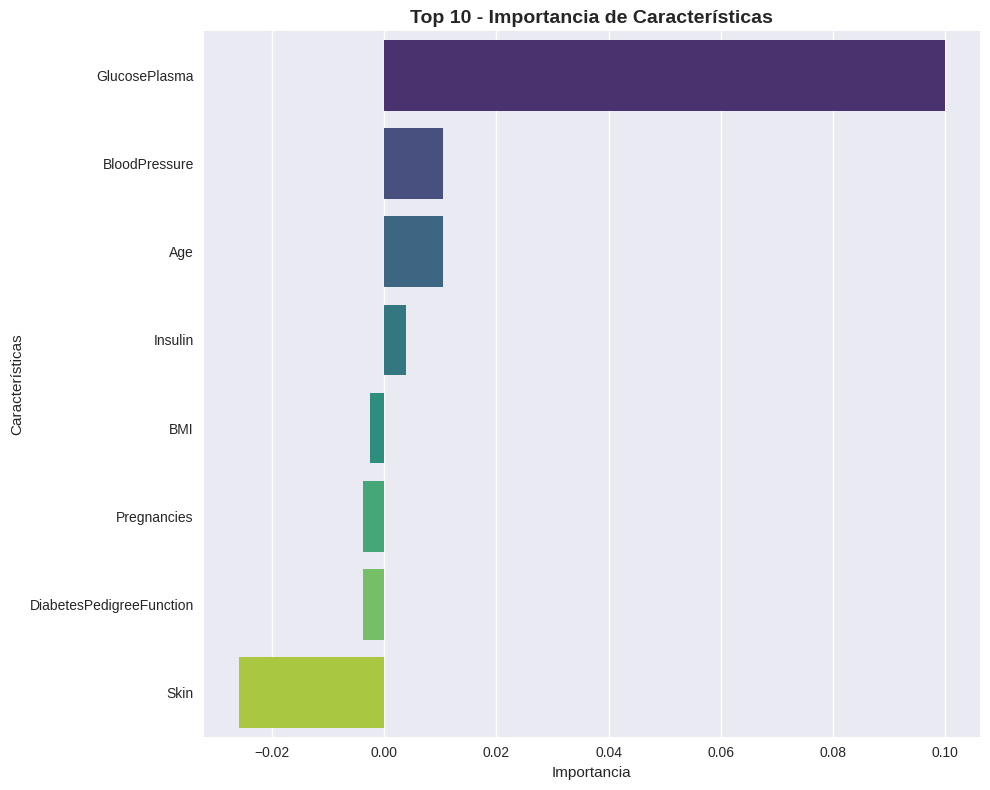

In [57]:
try:
    print("\n" + "=" * 60)
    print("EVALUACIÓN DE MODELOS")
    print("=" * 60)

    # Tabla de líderes (leaderboard)
    leaderboard = predictor.leaderboard(test_data, silent=True)
    print(" Tabla de Líderes (Top 10 modelos):")
    print(leaderboard.head(10))

    # Obtener el mejor modelo
    best_model = leaderboard.index[0]
    print(f"\n Mejor modelo: {best_model}")

    # Predicciones del mejor modelo
    predictions = predictor.predict(test_data)
    predictions_proba = predictor.predict_proba(test_data)

    # Si predict_proba devuelve un DataFrame, tomar la columna de clase positiva
    if isinstance(predictions_proba, pd.DataFrame):
        predictions_proba_positive = predictions_proba.iloc[:, 1]
    else:
        predictions_proba_positive = predictions_proba

    # Métricas del mejor modelo
    ag_accuracy = accuracy_score(y_test, predictions)
    ag_precision = precision_score(y_test, predictions)
    ag_recall = recall_score(y_test, predictions)
    ag_f1 = f1_score(y_test, predictions)
    ag_auc = roc_auc_score(y_test, predictions_proba_positive)

    autogluon_results = {
        'Modelo': f'AutoGluon - {best_model}',
        'Accuracy': ag_accuracy,
        'Precision': ag_precision,
        'Recall': ag_recall,
        'F1-Score': ag_f1,
        'AUC': ag_auc
    }

    print(f"\n Resultados del Mejor Modelo AutoGluon:")
    for metric, value in autogluon_results.items():
        if metric != 'Modelo':
            print(f"  {metric}: {value:.4f}")

    # Comparación de modelos
    print(f"\n COMPARACIÓN DE MODELOS:")
    comparison_df = pd.DataFrame([baseline_results, autogluon_results])
    print(comparison_df.round(4))

    # Importancia de características
    try:
        feature_importance = predictor.feature_importance(test_data)
        print(f"\n Importancia de Características (Top 10):")
        print(feature_importance.head(10))

        # Visualizar importancia de características
        plt.figure(figsize=(10, 8))
        top_features = feature_importance.head(10)
        sns.barplot(data=top_features.reset_index(),
                   x='importance', y='index', palette='viridis')
        plt.title('Top 10 - Importancia de Características', fontsize=14, fontweight='bold')
        plt.xlabel('Importancia')
        plt.ylabel('Características')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"No se pudo obtener la importancia de características: {e}")

except Exception as e:
    print(f"Error en la evaluación: {e}")
    # Usar resultados del baseline si AutoGluon falla
    predictions = y_pred_baseline
    predictions_proba_positive = y_pred_proba_baseline
    print("Usando resultados del modelo baseline para visualizaciones")



 Generando visualizaciones de evaluación...


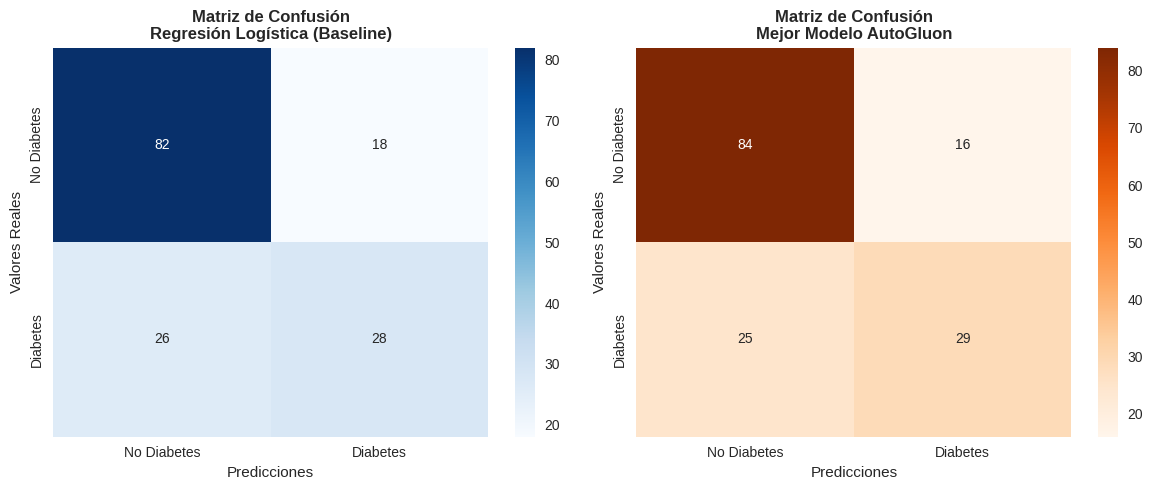

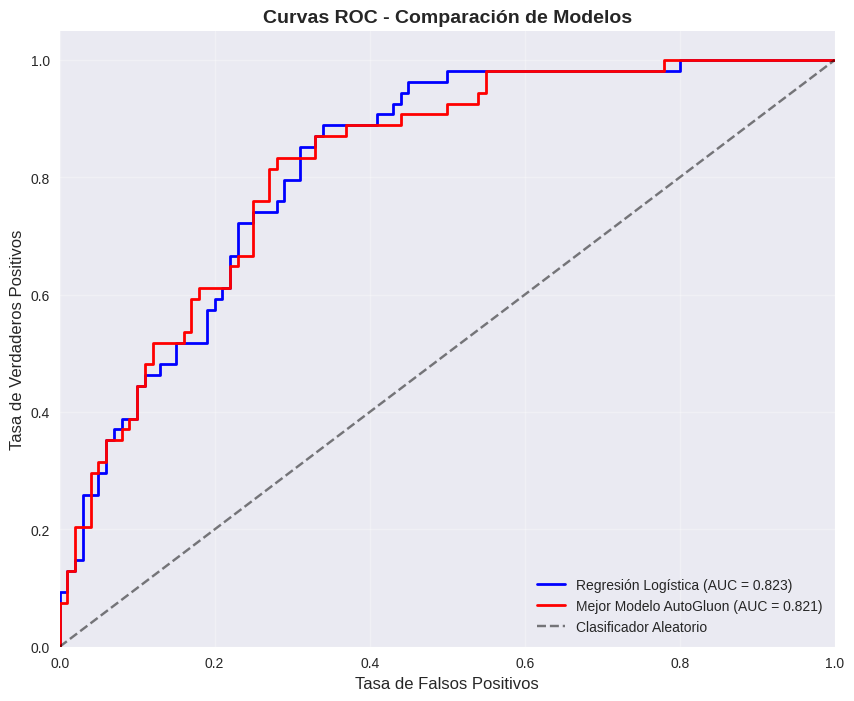


 REPORTE DE CLASIFICACIÓN DETALLADO:

🔵 Regresión Logística (Baseline):
              precision    recall  f1-score   support

 No Diabetes       0.76      0.82      0.79       100
    Diabetes       0.61      0.52      0.56        54

    accuracy                           0.71       154
   macro avg       0.68      0.67      0.67       154
weighted avg       0.71      0.71      0.71       154


🔴 Mejor Modelo AutoGluon:
              precision    recall  f1-score   support

 No Diabetes       0.77      0.84      0.80       100
    Diabetes       0.64      0.54      0.59        54

    accuracy                           0.73       154
   macro avg       0.71      0.69      0.69       154
weighted avg       0.73      0.73      0.73       154



In [58]:
# ===================================================================
# 9. VISUALIZACIONES DE EVALUACIÓN
# ===================================================================

print(f"\n Generando visualizaciones de evaluación...")

# Matriz de confusión
plt.figure(figsize=(12, 5))

# Matriz de confusión - Baseline
plt.subplot(1, 2, 1)
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Matriz de Confusión\nRegresión Logística (Baseline)', fontweight='bold')
plt.ylabel('Valores Reales')
plt.xlabel('Predicciones')

# Matriz de confusión - Mejor modelo
plt.subplot(1, 2, 2)
cm_best = confusion_matrix(y_test, predictions)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Matriz de Confusión\nMejor Modelo AutoGluon', fontweight='bold')
plt.ylabel('Valores Reales')
plt.xlabel('Predicciones')

plt.tight_layout()
plt.show()

# Curva ROC
plt.figure(figsize=(10, 8))

# ROC Baseline
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_pred_proba_baseline)
plt.plot(fpr_baseline, tpr_baseline,
         label=f'Regresión Logística (AUC = {baseline_auc:.3f})',
         linewidth=2, color='blue')

# ROC Mejor modelo
fpr_best, tpr_best, _ = roc_curve(y_test, predictions_proba_positive)
auc_best = roc_auc_score(y_test, predictions_proba_positive)
plt.plot(fpr_best, tpr_best,
         label=f'Mejor Modelo AutoGluon (AUC = {auc_best:.3f})',
         linewidth=2, color='red')

# Línea diagonal (clasificador aleatorio)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Clasificador Aleatorio')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos', fontsize=12)
plt.title('Curvas ROC - Comparación de Modelos', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Reporte de clasificación detallado
print(f"\n REPORTE DE CLASIFICACIÓN DETALLADO:")
print(f"\n🔵 Regresión Logística (Baseline):")
print(classification_report(y_test, y_pred_baseline,
                          target_names=['No Diabetes', 'Diabetes']))

print(f"\n🔴 Mejor Modelo AutoGluon:")
print(classification_report(y_test, predictions,
                          target_names=['No Diabetes', 'Diabetes']))